In [1]:
!pip install sqlalchemy
!pip install pyodbc

In [2]:
## Importing all the necessary libraries
from sqlalchemy import create_engine, Table, inspect
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

#  Creating Engine

In [3]:
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # For SQL Server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [4]:
# For Windows authentication
# Replace the server argument with the Server Name found when logging into SQL Server Management Studio 
# OR
# For SQL Server authentication
# Replace the server, user and password argument with the Server Name, username and password
engine = new_engine('mssql', 'DESKTOP-H7O4R1L', 'AdventureWorks2022', integrated_security=True)

mssql://DESKTOP-H7O4R1L/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server


In [5]:
print(type(engine))

<class 'sqlalchemy.engine.base.Engine'>


# Creating Connection

In [6]:
connection = engine.connect()

In [7]:
print(type(connection))

<class 'sqlalchemy.engine.base.Connection'>


# Inspecting the Database

In [8]:
# To get all the schema name from the database
inspector = inspect(engine)
schemas = inspector.get_schema_names()
print(schemas)

['db_accessadmin', 'db_backupoperator', 'db_datareader', 'db_datawriter', 'db_ddladmin', 'db_denydatareader', 'db_denydatawriter', 'db_owner', 'db_securityadmin', 'dbo', 'guest', 'HumanResources', 'INFORMATION_SCHEMA', 'Person', 'Production', 'Purchasing', 'Sales', 'sys']


In [9]:
for schema in schemas:
    print(schema)

db_accessadmin
db_backupoperator
db_datareader
db_datawriter
db_ddladmin
db_denydatareader
db_denydatawriter
db_owner
db_securityadmin
dbo
guest
HumanResources
INFORMATION_SCHEMA
Person
Production
Purchasing
Sales
sys


In [10]:
print("Number of schemas in the database Adventureworks2022 - ",len(schemas))

Number of schemas in the database Adventureworks2022 -  18


In [11]:
# Print all table names in all schemas
all_table_names = []
for schema_name in inspector.get_schema_names():
    tables = inspector.get_table_names(schema=schema_name)
    all_table_names.extend([(schema_name, table) for table in tables])

print("All tables in all schemas:")
print(all_table_names)

All tables in all schemas:
[('dbo', 'AWBuildVersion'), ('dbo', 'DatabaseLog'), ('dbo', 'ErrorLog'), ('HumanResources', 'Department'), ('HumanResources', 'Employee'), ('HumanResources', 'EmployeeDepartmentHistory'), ('HumanResources', 'EmployeePayHistory'), ('HumanResources', 'JobCandidate'), ('HumanResources', 'Shift'), ('Person', 'Address'), ('Person', 'AddressType'), ('Person', 'BusinessEntity'), ('Person', 'BusinessEntityAddress'), ('Person', 'BusinessEntityContact'), ('Person', 'ContactType'), ('Person', 'CountryRegion'), ('Person', 'EmailAddress'), ('Person', 'MyPersonPhoneTable'), ('Person', 'Password'), ('Person', 'Person'), ('Person', 'PersonPhone'), ('Person', 'PhoneNumberType'), ('Person', 'StateProvince'), ('Production', 'BillOfMaterials'), ('Production', 'Culture'), ('Production', 'Document'), ('Production', 'Illustration'), ('Production', 'Location'), ('Production', 'Product'), ('Production', 'ProductCategory'), ('Production', 'ProductCostHistory'), ('Production', 'Product

In [12]:
print("Number of tables in the database Adventureworks2022 - ",len(all_table_names))

Number of tables in the database Adventureworks2022 -  72


In [13]:
# To check no of tables in Production schema.
inspector = inspect(engine)
tables = inspector.get_table_names('Production')
print(tables)

['BillOfMaterials', 'Culture', 'Document', 'Illustration', 'Location', 'Product', 'ProductCategory', 'ProductCostHistory', 'ProductDescription', 'ProductDocument', 'ProductInventory', 'ProductListPriceHistory', 'ProductModel', 'ProductModelIllustration', 'ProductModelProductDescriptionCulture', 'ProductPhoto', 'ProductProductPhoto', 'ProductReview', 'ProductSubcategory', 'ScrapReason', 'TransactionHistory', 'TransactionHistoryArchive', 'UnitMeasure', 'WorkOrder', 'WorkOrderRouting']


In [14]:
print("Number of tables in Production schema - ",len(tables))

Number of tables in Production schema -  25


In [15]:
# To inspect specific table columns in a specific schema and its useful to contruct queries.

for col in inspector.get_columns(table_name='Product', schema='Production'):
    print(col['name'])

ProductID
Name
ProductNumber
MakeFlag
FinishedGoodsFlag
Color
SafetyStockLevel
ReorderPoint
StandardCost
ListPrice
Size
SizeUnitMeasureCode
WeightUnitMeasureCode
Weight
DaysToManufacture
ProductLine
Class
Style
ProductSubcategoryID
ProductModelID
SellStartDate
SellEndDate
DiscontinuedDate
rowguid
ModifiedDate


In [16]:
for col in inspector.get_columns(table_name='ProductCostHistory', schema='Production'):
    print(col['name'])

ProductID
StartDate
EndDate
StandardCost
ModifiedDate


In [17]:
for col in inspector.get_columns(table_name='ProductListPriceHistory', schema='Production'):
    print(col['name'])

ProductID
StartDate
EndDate
ListPrice
ModifiedDate


In [18]:
for col in inspector.get_columns(table_name='TransactionHistory', schema='Production'):
    print(col['name'])

TransactionID
ProductID
ReferenceOrderID
ReferenceOrderLineID
TransactionDate
TransactionType
Quantity
ActualCost
ModifiedDate


# Querying the Database

In [19]:
## I chosed to work on production schema which has CostPrice, ListPrice, TotalSales and ProductionType.
## I chosed it because it has price and sales data which are very useful to optimize the business.
## These are all data i have taken further to statistical analysis.

sql_code ="""
-- Creating the CTE expression name and column list.
WITH CTE1 (ProductID, StandardCost)
AS
(
	SELECT ProductID,
	AVG(StandardCost) 
	FROM Production.ProductCostHistory
	GROUP BY ProductID
),

CTE2 (ProductID, ListPrice)
AS
(
	SELECT ProductID,
	AVG(ListPrice)
	FROM Production.ProductListPriceHistory
	GROUP BY ProductID
)

SELECT A.ProductID,
	C.[Name],
	C.MakeFlag as InhouseProduct,
	D.TotalQuantity as CurrentStock,
	A.StandardCost,
	B.ListPrice as SellingPrice,
	E.TotalQuantity as TotalSales
FROM CTE1 as A INNER JOIN CTE2 as B
	ON A.ProductID = B.ProductID
LEFT JOIN Production.Product as C
	ON A.ProductID = C.ProductID
LEFT JOIN 
-- Creating Subquery
(
	SELECT ProductID,
	SUM(Quantity) as TotalQuantity
	FROM Production.ProductInventory
	GROUP BY ProductID
)
	as D
	ON A.ProductID = D.ProductID
LEFT JOIN 
(
	SELECT ProductID,
	SUM(Quantity) as TotalQuantity
	FROM Production.TransactionHistory
	GROUP BY ProductID
)
	as E
	ON A.ProductID = E.ProductID
ORDER BY ProductID ASC"""


In [20]:
## Reading the data from SQl server and store it.
sql_df = pd.read_sql(sql=sql_code, con=connection)

# Data Inspection

In [21]:
## To preview the data
sql_df.head()

,ProductID,Name,InhouseProduct,CurrentStock,StandardCost,SellingPrice,TotalSales
0,707,"Sport-100 Helmet, Red",False,288.0,12.9974,34.0928,3542.0
1,708,"Sport-100 Helmet, Black",False,324.0,12.9974,34.0928,3609.0
2,709,"Mountain Bike Socks, M",False,180.0,3.3963,9.5000,NaN
3,710,"Mountain Bike Socks, L",False,216.0,3.3963,9.5000,NaN
4,711,"Sport-100 Helmet, Blue",False,216.0,12.9974,34.0928,3608.0


In [22]:
## To know no of rows and columns in the dataframe.
sql_df.shape

(293, 7)

In [23]:
## To know no of records in the dataframe.
sql_df.size

2051

In [24]:
##  It gives basic information about each columns in the dataframe.
sql_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ProductID       293 non-null    int64  
 1   Name            293 non-null    object 
 2   InhouseProduct  293 non-null    bool   
 3   CurrentStock    223 non-null    float64
 4   StandardCost    293 non-null    float64
 5   SellingPrice    293 non-null    float64
 6   TotalSales      231 non-null    float64
dtypes: bool(1), float64(4), int64(1), object(1)
memory usage: 14.1+ KB


In [25]:
##  It provides the statistical summaries of all numerical attributes in the dataframe.
sql_df.describe()

,ProductID,CurrentStock,StandardCost,SellingPrice,TotalSales
count,293.000000,223.000000,293.000000,293.000000,231.000000
mean,853.000000,348.959641,423.000104,726.527840,6410.870130
std,84.726029,283.538458,525.093661,882.200218,11583.057073
min,707.000000,0.000000,0.856500,2.290000,1.000000
25%,780.000000,148.000000,33.099100,63.500000,704.500000
50%,853.000000,188.000000,199.375700,333.420000,1448.000000
75%,926.000000,551.500000,601.743700,1060.463700,3740.000000
max,999.000000,989.000000,2171.294200,3578.270000,50922.000000


In [26]:
## To shows how many times True/False appears in that specific column.
sql_df.value_counts('InhouseProduct')

InhouseProduct
True     210
False     83
Name: count, dtype: int64

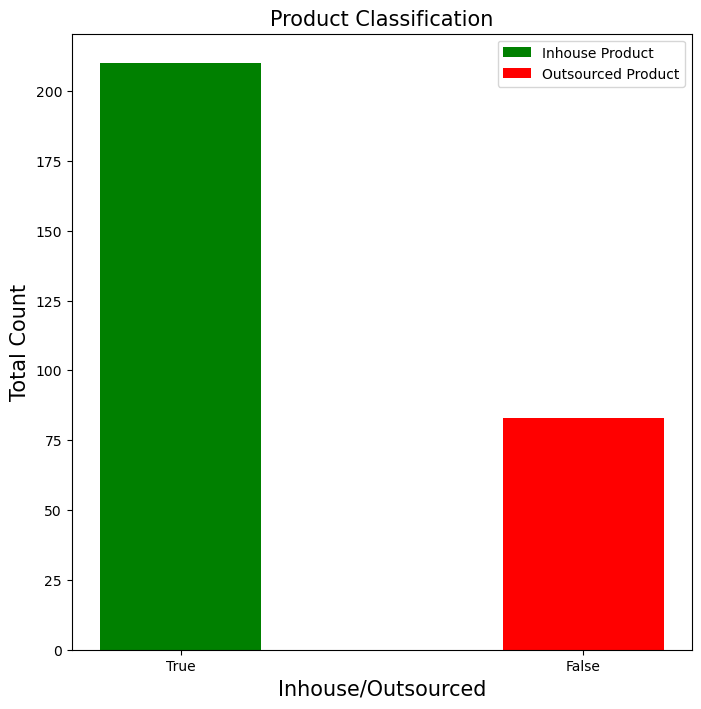

In [27]:
## To visualize above result by plotting. It shows how many products are manufactured inhouse or not.

counts = sql_df['InhouseProduct'].value_counts()
## Plotting
figure, ax = plt.subplots(figsize = (8, 8))
ax.bar(counts.index.astype(str), counts.values, width=0.4, color=['green', 'red'], label=['Inhouse Product', 'Outsourced Product'])
ax.set_xlabel('Inhouse/Outsourced', size = 15)
ax.set_ylabel('Total Count', size = 15)
ax.set_title('Product Classification', size = 15)
ax.legend(loc='upper right')

# Treating Null Values

In [28]:
# To find no of null values in the columns
sql_df.isnull().sum()

ProductID          0
Name               0
InhouseProduct     0
CurrentStock      70
StandardCost       0
SellingPrice       0
TotalSales        62
dtype: int64

In [29]:
# We can fill the null values with the 'CurrentStock' mean
stock_mean = sql_df['CurrentStock'].mean()
sql_df['CurrentStock'].fillna(stock_mean, inplace=True)

In [30]:
# Drops all rows containing missing data
sql_df.dropna(inplace=True)

# Total Sales Analysis

In [31]:
sql_df[['ProductID', 'TotalSales']]

,ProductID,TotalSales
0,707,3542.0
1,708,3609.0
4,711,3608.0
5,712,4133.0
6,713,394.0
...,...,...
288,995,12521.0
289,996,8565.0
290,997,1134.0
291,998,2513.0


Text(0.5, 1.0, 'Sales Distribution')

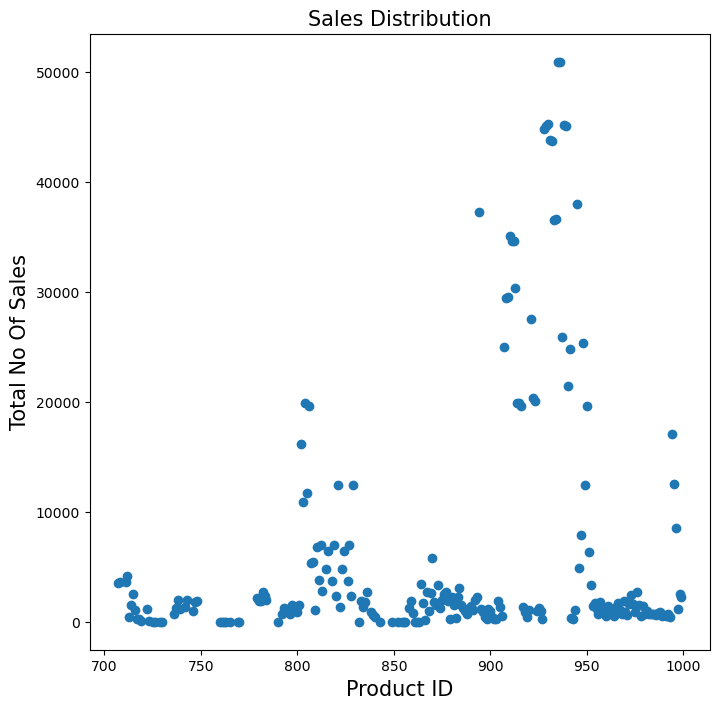

In [32]:
## To visualize the TotalSales of all the products by plottting.
figure, ax = plt.subplots(figsize = (8, 8))  
ax.scatter(sql_df['ProductID'],sql_df['TotalSales'])
ax.set_xlabel('Product ID', size = 15)
ax.set_ylabel('Total No Of Sales', size = 15)
ax.set_title('Sales Distribution', size = 15)

In [33]:
## To set 'ProductID' as an index. so that we can easily use .loc method to put our needed condition.
sql_df.set_index('ProductID',  inplace=True)

In [34]:
##sql_df.loc[900:950, :]

In [35]:
## Fetching the data whose ProductID between 900 and 950. and also total sales above 19000.
## because these data points are high sales in that chart. so that we can analyze furthur.

sql_df2 = sql_df.loc[(sql_df.index >= 900) & (sql_df.index <= 950) & (sql_df['TotalSales'] > 19000)]
sql_df2

,Name,InhouseProduct,CurrentStock,StandardCost,SellingPrice,TotalSales
ProductID,,,,,,
907,Rear Brakes,False,723.0,47.2860,106.50,24937.0
908,LL Mountain Seat/Saddle,False,809.0,12.0413,27.12,29404.0
909,ML Mountain Seat/Saddle,False,422.0,17.3782,39.14,29555.0
910,HL Mountain Seat/Saddle,False,355.0,23.3722,52.64,35051.0
911,LL Road Seat/Saddle,False,906.0,12.0413,27.12,34659.0
912,ML Road Seat/Saddle,False,901.0,17.3782,39.14,34650.0
913,HL Road Seat/Saddle,False,467.0,23.3722,52.64,30304.0
914,LL Touring Seat/Saddle,False,801.0,12.0413,27.12,19847.0
915,ML Touring Seat/Saddle,False,402.0,17.3782,39.14,19853.0


In [36]:
## To check no of inhouse products after certain condition passed.
sql_df2.value_counts('InhouseProduct')

InhouseProduct
False    28
True      2
Name: count, dtype: int64

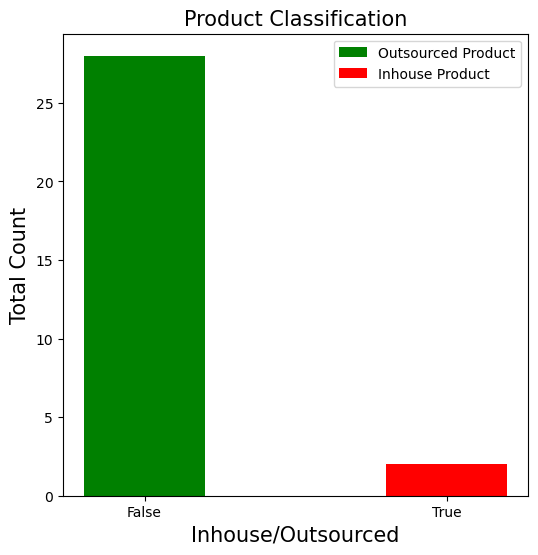

In [37]:
## To visualize above result by plotting. It shows how many products are manufactured inhouse or not.
counts2 = sql_df2['InhouseProduct'].value_counts()

## Plotting
figure, ax = plt.subplots(figsize = (6, 6))
ax.bar(counts2.index.astype(str), counts2.values, width=0.4, color=['green', 'red'], label=['Outsourced Product', 'Inhouse Product'])
ax.set_xlabel('Inhouse/Outsourced', size = 15)
ax.set_ylabel('Total Count', size = 15)
ax.set_title('Product Classification', size = 15)
ax.legend(loc='upper right')

# Profit Percentage Analysis

In [38]:
## Selecting the columns from the dataframe
sql_df[['StandardCost', 'SellingPrice']]

,StandardCost,SellingPrice
ProductID,,
707,12.9974,34.0928
708,12.9974,34.0928
711,12.9974,34.0928
712,5.9524,8.7594
713,33.0991,48.7082
...,...,...
995,44.9506,101.2400
996,53.9416,121.4900
997,343.6496,539.9900


In [39]:
## Subtracting to get the profit and create new column 'Profit'
sql_df['Profit'] = sql_df['SellingPrice'].sub(sql_df['StandardCost'])

In [40]:
## To get the profit percentage for each product
sql_df['ProfitPercentage'] = sql_df.apply(lambda row: ((row['Profit'])/row['StandardCost'])*100, axis=1)

In [41]:
## preview. new columns are created.
sql_df.head()

,Name,InhouseProduct,CurrentStock,StandardCost,SellingPrice,TotalSales,Profit,ProfitPercentage
ProductID,,,,,,,,
707,"Sport-100 Helmet, Red",False,288.0,12.9974,34.0928,3542.0,21.0954,162.304769
708,"Sport-100 Helmet, Black",False,324.0,12.9974,34.0928,3609.0,21.0954,162.304769
711,"Sport-100 Helmet, Blue",False,216.0,12.9974,34.0928,3608.0,21.0954,162.304769
712,AWC Logo Cap,False,288.0,5.9524,8.7594,4133.0,2.8070,47.157449
713,"Long-Sleeve Logo Jersey, S",False,144.0,33.0991,48.7082,394.0,15.6091,47.158684


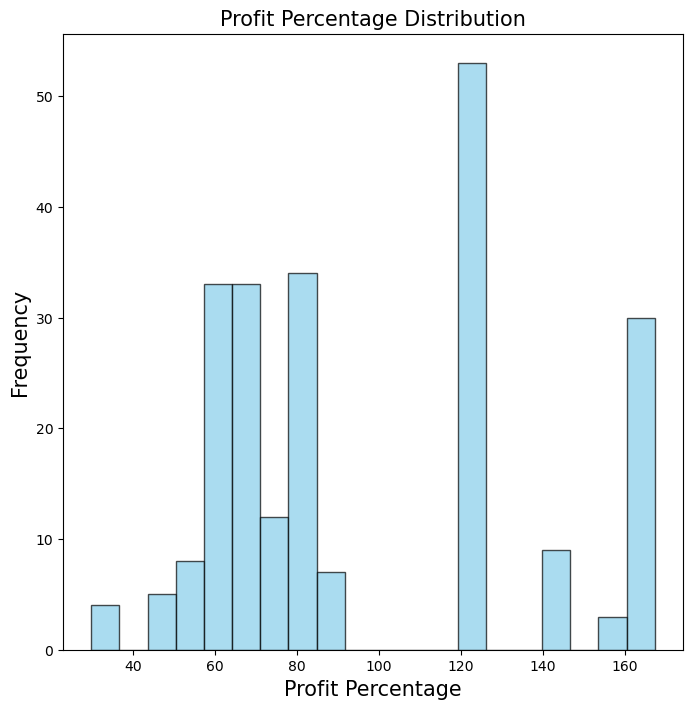

In [42]:
# Creating a histogram
figure, ax = plt.subplots(figsize=(8, 8))
ax.hist(sql_df['ProfitPercentage'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
ax.set_xlabel('Profit Percentage', size=15)
ax.set_ylabel('Frequency', size=15)
ax.set_title('Profit Percentage Distribution', size=15)
plt.show()

In [43]:
#Profit_Percentage = sql_df.ProfitPercentage
#ci = stats.norm.interval(0.95, loc=np.mean(Profit_Percentage), scale=stats.sem(Profit_Percentage))

#print(f"Confidence Interval for Average Profit Percentage: {ci}")

## Confidence interval for two different group

In [44]:
## confidence interval for the whole data gives (93.46, 103.47) which is illogical if you check above chart.
## To get precise confidence interval, we divide into two groups and then calculated.

In [45]:
## Group 1 - calculate confidence interval for the profit percentage between 50 and 100

sql_df3 = sql_df.loc[(sql_df['ProfitPercentage'] >= 50) & (sql_df['ProfitPercentage'] <= 100)]
Profit_Percentage1 = sql_df3.ProfitPercentage

ci = stats.norm.interval(0.95, loc=np.mean(Profit_Percentage1), scale=stats.sem(Profit_Percentage1))

print(f"Confidence Interval for Average Profit Percentage: {ci}")

Confidence Interval for Average Profit Percentage: (69.14707382706457, 72.61772611320846)


In [46]:
## Group 2- calculate confidence interval for the profit percentage between 100 and 180

sql_df4 = sql_df.loc[(sql_df['ProfitPercentage'] >= 100) & (sql_df['ProfitPercentage'] <= 180)]
Profit_Percentage2 = sql_df4.ProfitPercentage

ci = stats.norm.interval(0.95, loc=np.mean(Profit_Percentage2), scale=stats.sem(Profit_Percentage2))

print(f"Confidence Interval for Average Profit Percentage: {ci}")

Confidence Interval for Average Profit Percentage: (137.11215113897947, 144.75013922199554)


## Difference between two groups mean

In [47]:
# Calculate statistics for each group
mean1, std1, size1 = sql_df3['ProfitPercentage'].mean(), sql_df3['ProfitPercentage'].std(ddof=1), len(sql_df3['ProfitPercentage'])
mean2, std2, size2 = sql_df4['ProfitPercentage'].mean(), sql_df4['ProfitPercentage'].std(ddof=1), len(sql_df4['ProfitPercentage'])

# Set the confidence level and calculate the critical value
confidence_level = 0.95
degrees_of_freedom = min(size1 - 1, size2 - 1)
critical_value = stats.t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

# Calculate the standard error of the difference between means
standard_error_diff = np.sqrt((std1**2 / size1) + (std2**2 / size2))

margin_of_error = critical_value * standard_error_diff
confidence_interval = (mean2 - mean1 - margin_of_error, mean2 - mean1 + margin_of_error)

print(f"95% Confidence Interval for the Difference: {confidence_interval}")

95% Confidence Interval for the Difference: (65.79927492391835, 74.29821549678363)
